In [1]:
import torch
from classes.MyModel import MyModel

from modules.helper_functions_tsp import (find_problem_size, 
                                          cost_fn_fact, 
                                          cost_fn_tensor,
                                          read_index, 
                                          hot_start, 
                                          hot_start_list_to_string,
                                          update_parameters_using_gradient, 
                                          define_parameters, 
                                          create_initial_rotations,
                                          bind_weights, 
                                          vqc_circuit, 
                                          cost_func_evaluate, 
                                          find_run_stats,
                                          find_distances_array,
                                          format_boolean,
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model)

from classes.DataLogger import DataLogger, SubDataLogger

import copy
import time
from pathlib import Path

from modules.config import(CONTROL_DIR, 
                           CONTROL_FILE, 
                           ENCODING, 
                           CACHE_MAX_SIZE)

Load control data and instantiate data logger

In [2]:
control_path = Path(CONTROL_DIR).joinpath(CONTROL_FILE)
control_dict = read_index(control_path, ENCODING)
print(f'Reading control data from {control_path}')
print(control_dict)
datalogger = DataLogger()
EMPTY = ' '

Reading control data from control\control_parameters.csv
{0: {'quantum': 'TRUE', 'locations': '6', 'slice': '1', 'shots': '1024', 'layers': '', 'std_dev': '', 'mode': '2', 'iterations': '250', 'gray': 'FALSE', 'hot_start': 'TRUE', 'gradient_type': 'SPSA', 'formulation': 'original', 'lr': '', 'weight_decay': '', 'momentum': '', 'alpha': '0.602', 'big_a': '50', 'c': '0.314', 'eta': '0.02', 'gamma': '0.101', 's': '0.5'}, 1: {'quantum': 'TRUE', 'locations': '7', 'slice': '1', 'shots': '1024', 'layers': '', 'std_dev': '', 'mode': '2', 'iterations': '250', 'gray': 'FALSE', 'hot_start': 'TRUE', 'gradient_type': 'SPSA', 'formulation': 'original', 'lr': '', 'weight_decay': '', 'momentum': '', 'alpha': '0.602', 'big_a': '50', 'c': '0.314', 'eta': '0.02', 'gamma': '0.101', 's': '0.5'}, 2: {'quantum': 'TRUE', 'locations': '8', 'slice': '1', 'shots': '1024', 'layers': '', 'std_dev': '', 'mode': '2', 'iterations': '250', 'gray': 'FALSE', 'hot_start': 'TRUE', 'gradient_type': 'SPSA', 'formulation': '

## Main loop

Data logger instantiated.  Run ID: 20250325-21-20-09
Detailed results are saved in folder results\20250325-21-20-09
Graphs are saved in folder graphs\20250325-21-20-09
SubDataLogger instantiated.  Run ID = 20250325-21-20-09 - 21-20-09
Reading distance data
Detailed data for Run ID: 20250325-21-20-09 - 21-20-09 successfully added to results\20250325-21-20-09\21-20-09.csv
Graph for Run ID: 20250325-21-20-09-21-20-09 saved to graphs\20250325-21-20-09\21-20-09.png
Summary data for Run ID: 20250325-21-20-09 - 21-20-09 successfully added to results\results.csv
Data logger instantiated.  Run ID: 20250325-21-20-23
Detailed results are saved in folder results\20250325-21-20-09
Graphs are saved in folder graphs\20250325-21-20-09
SubDataLogger instantiated.  Run ID = 20250325-21-20-09 - 21-20-23
Reading distance data
Detailed data for Run ID: 20250325-21-20-09 - 21-20-23 successfully added to results\20250325-21-20-09\21-20-23.csv
Graph for Run ID: 20250325-21-20-09-21-20-23 saved to graphs\20250

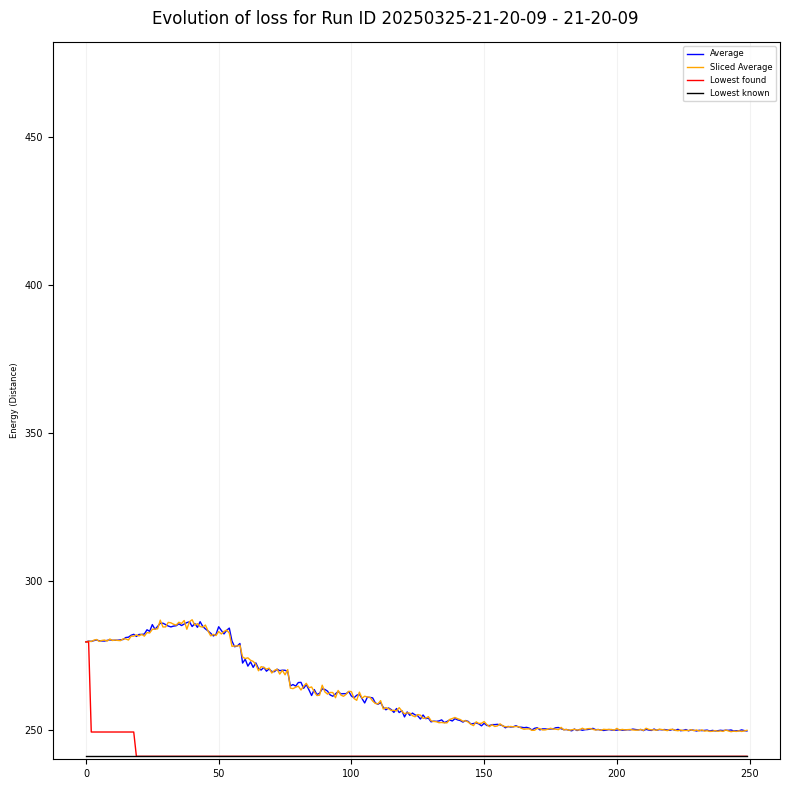

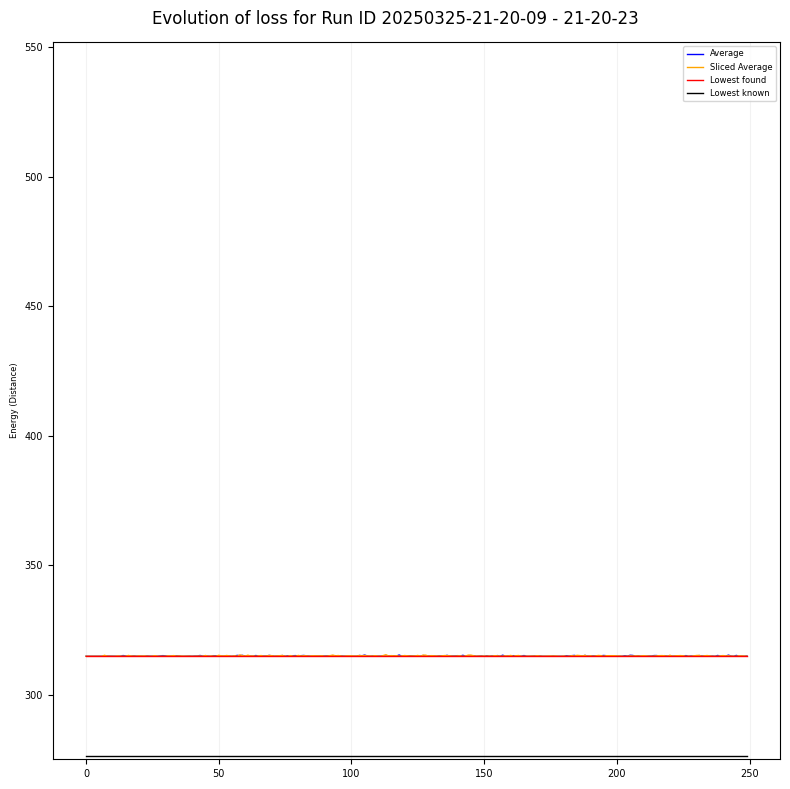

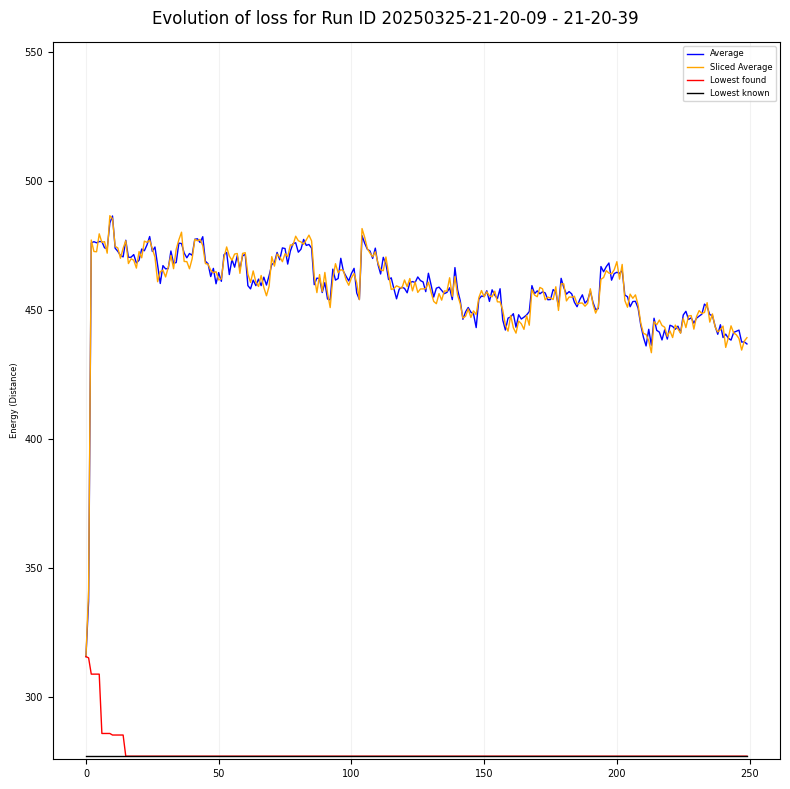

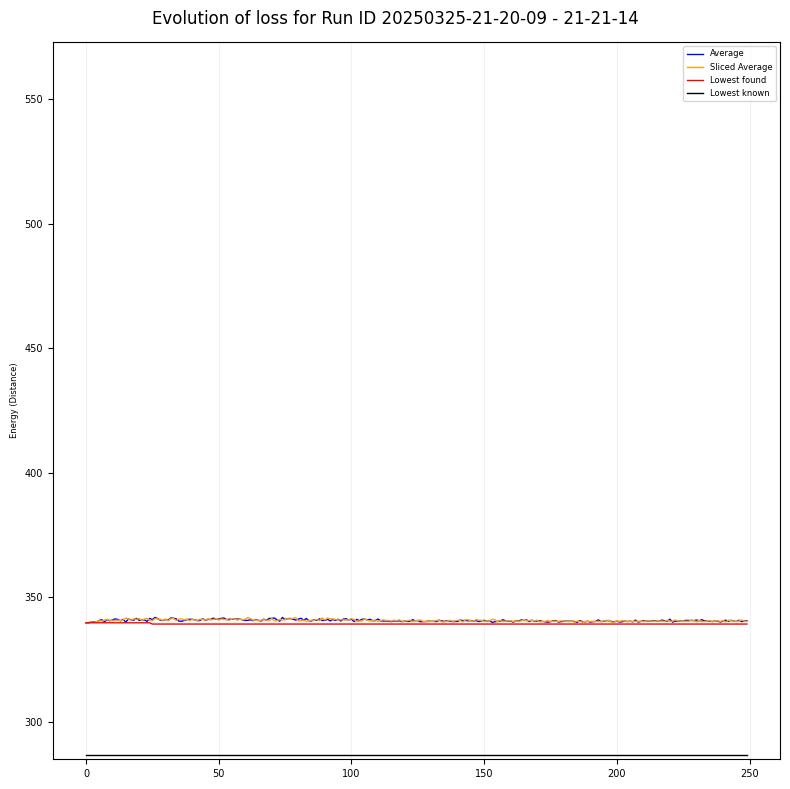

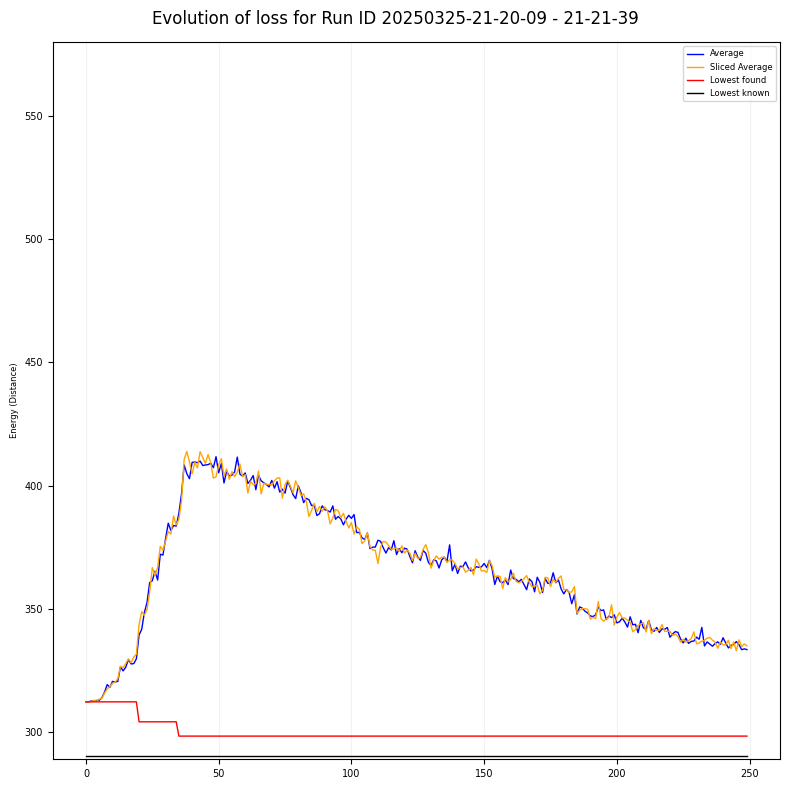

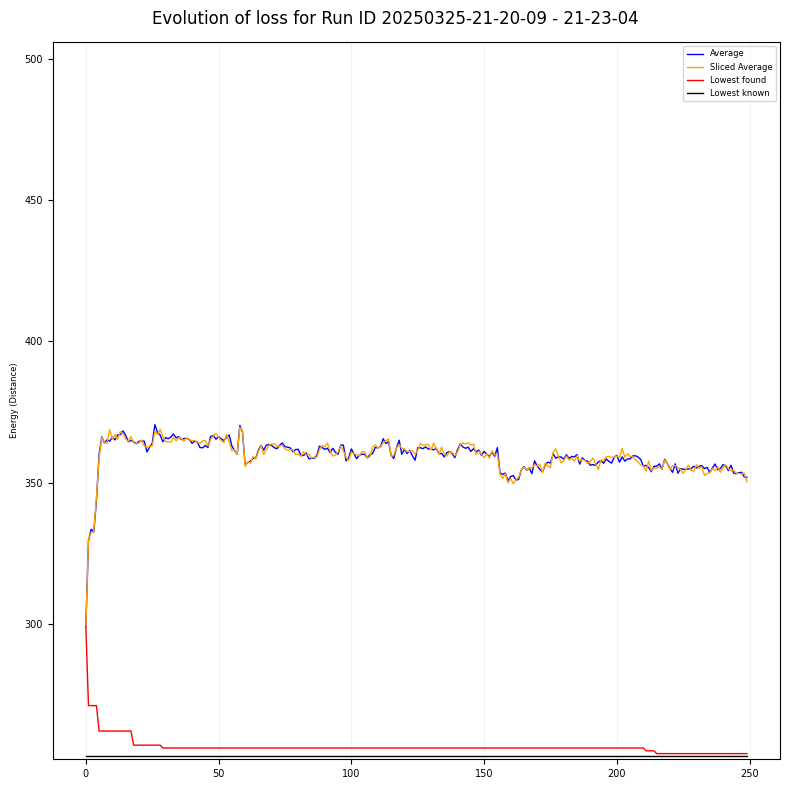

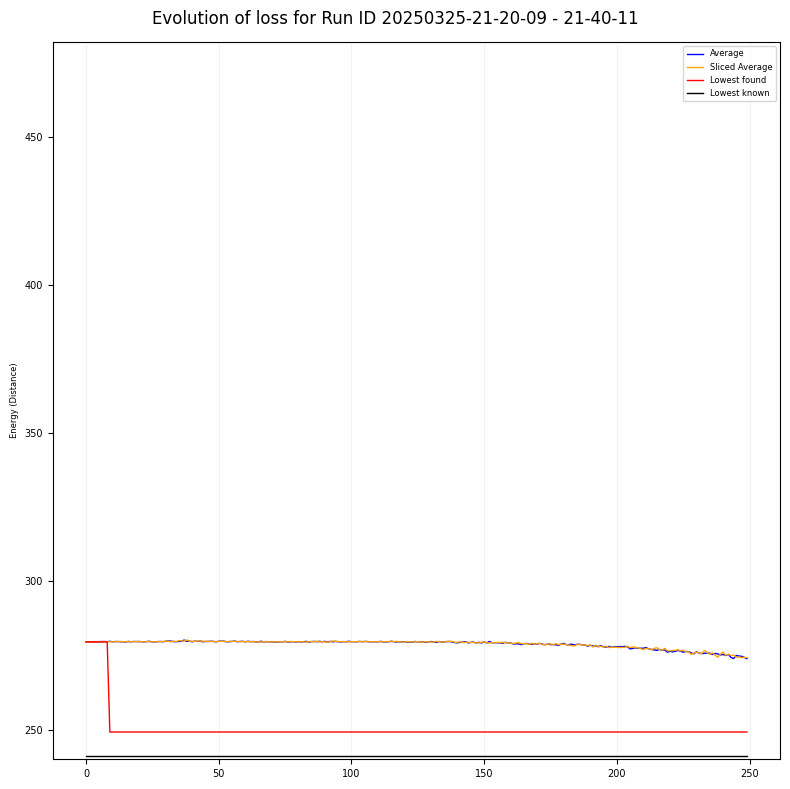

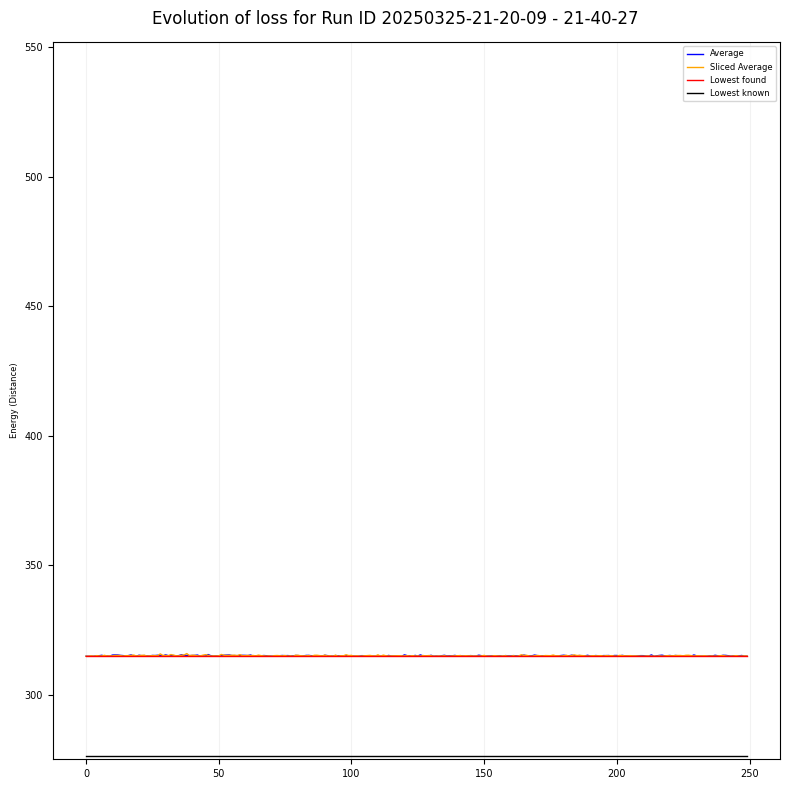

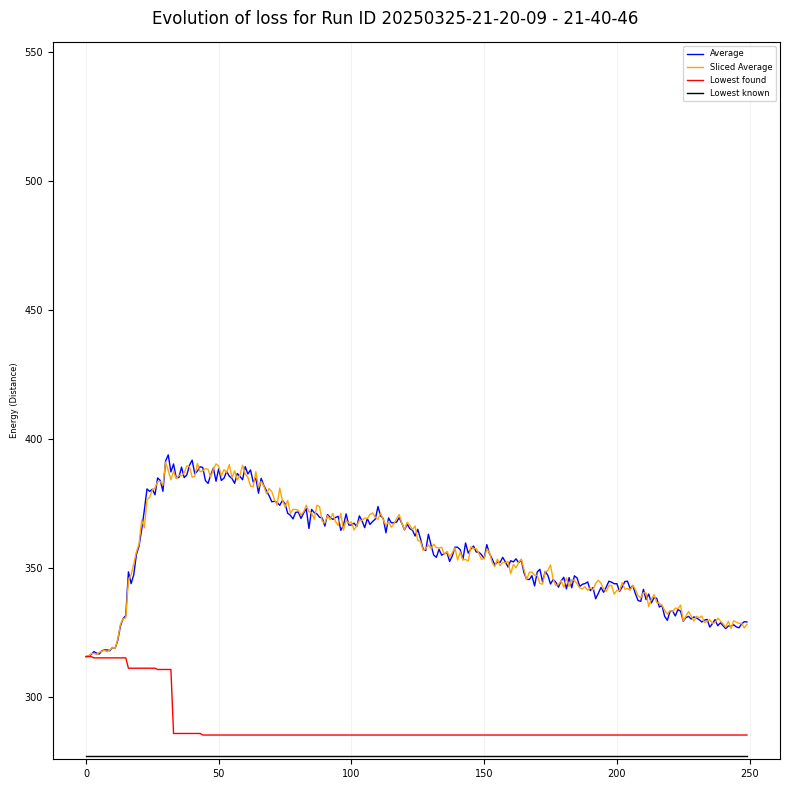

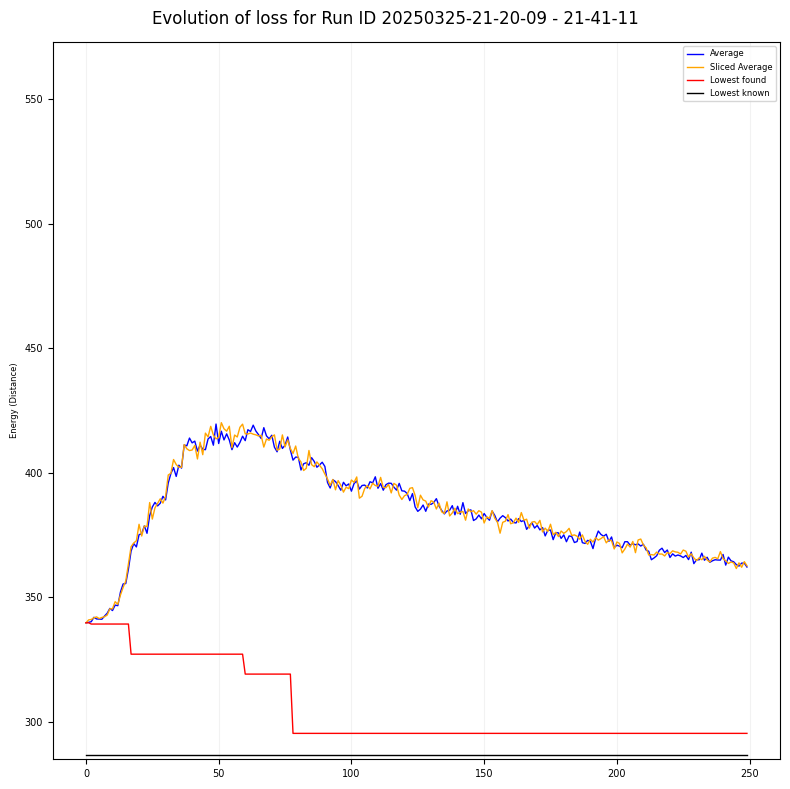

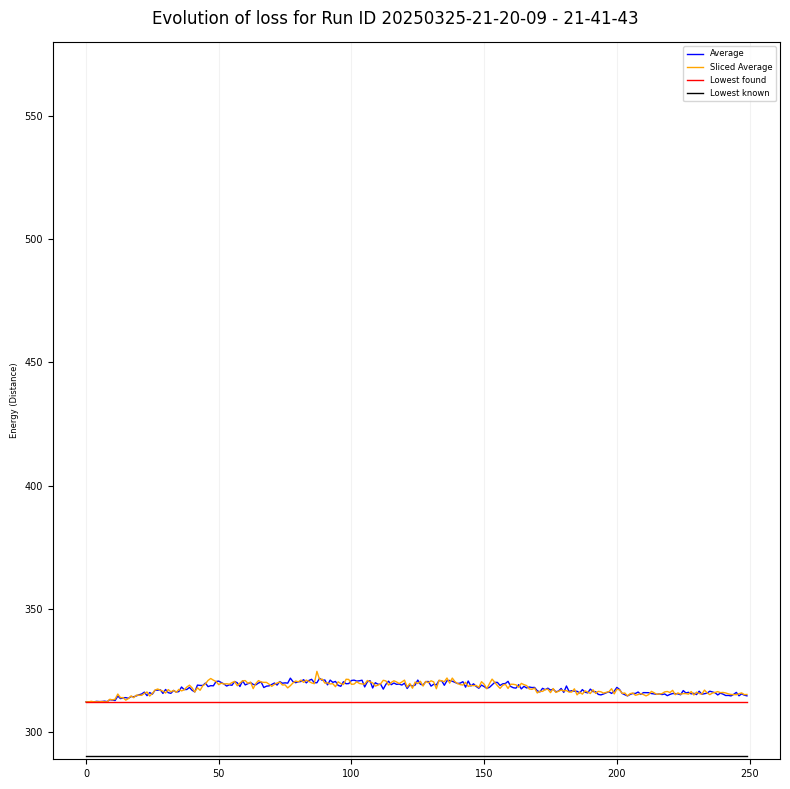

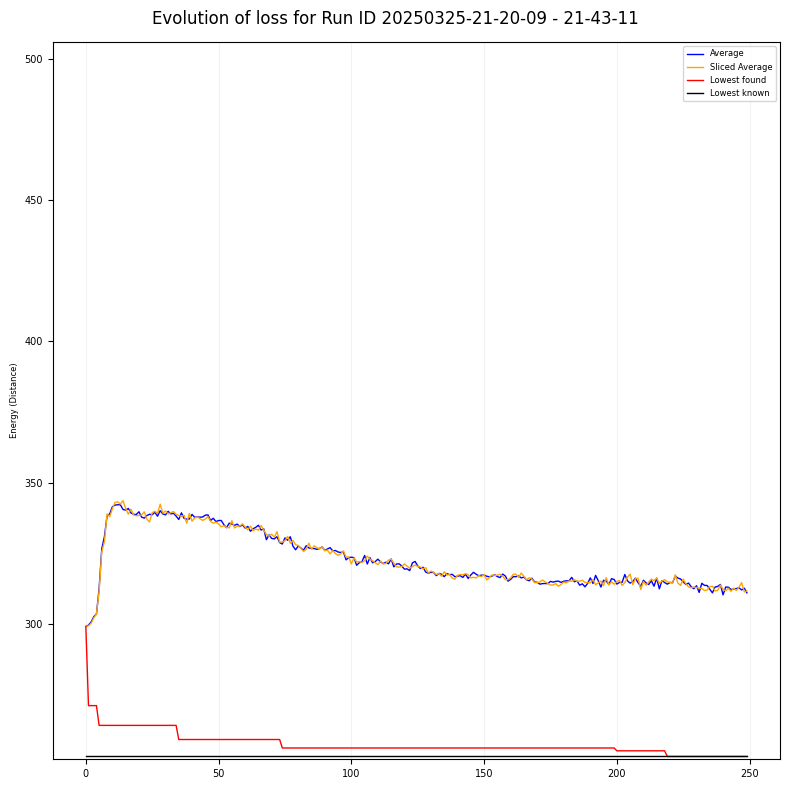

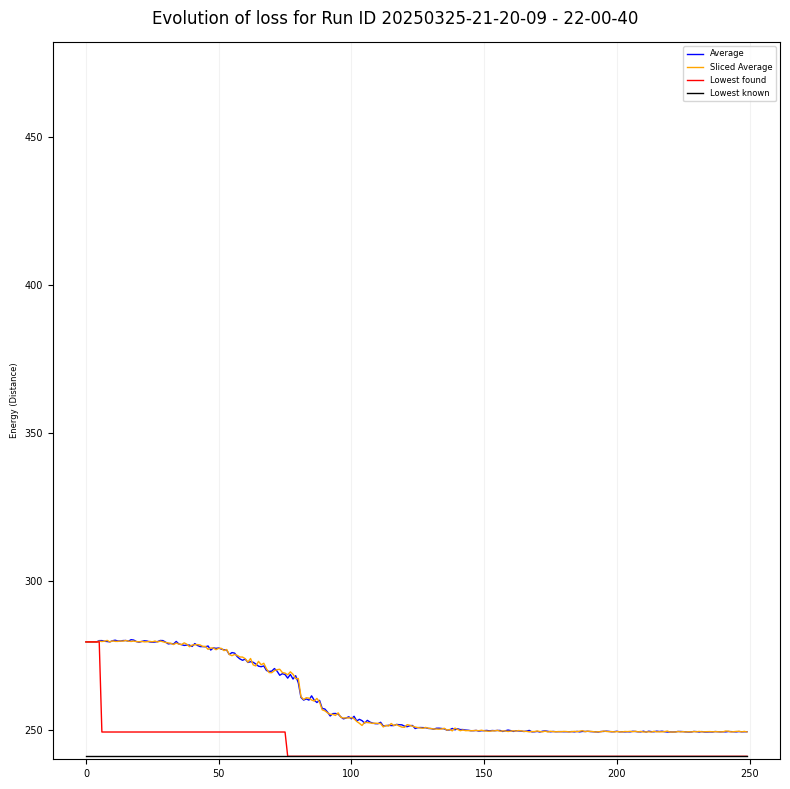

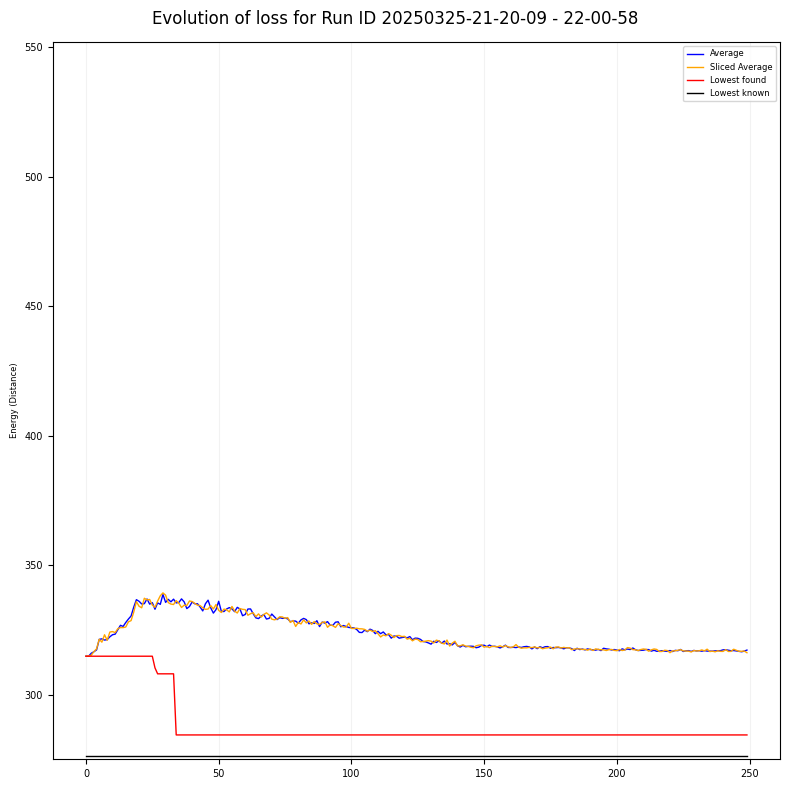

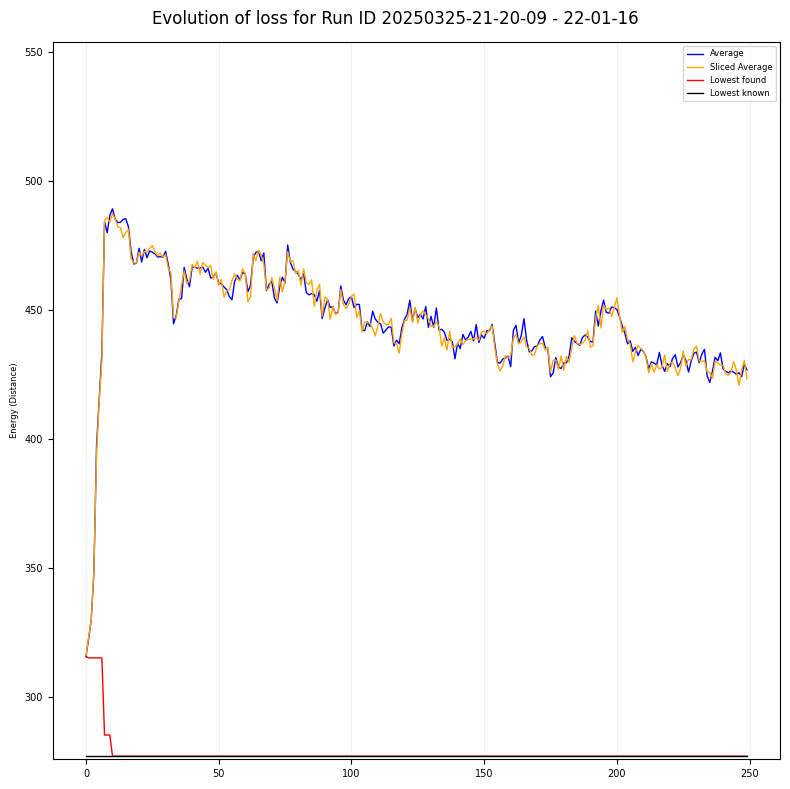

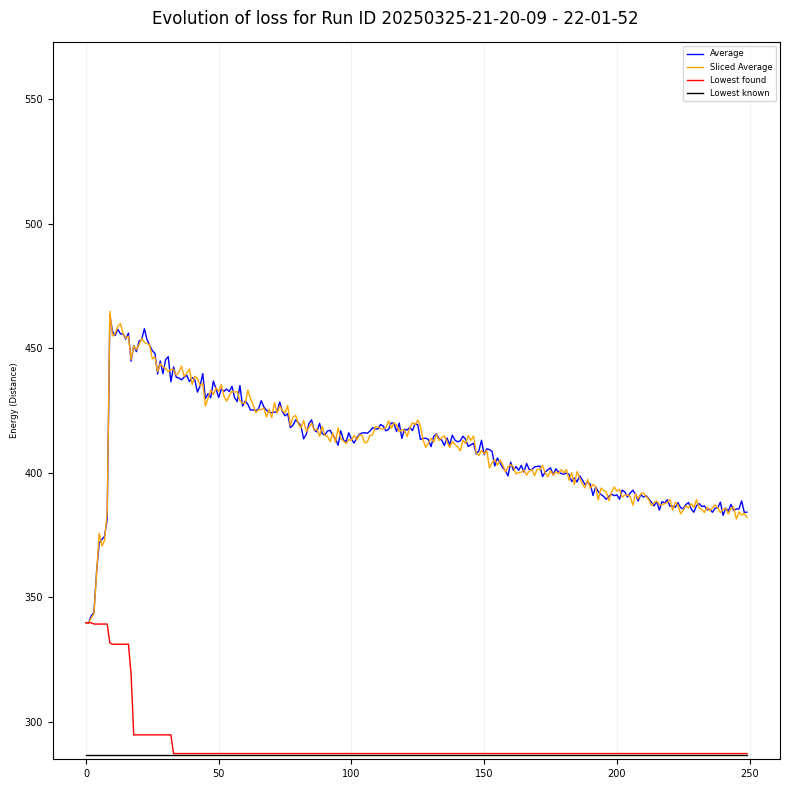

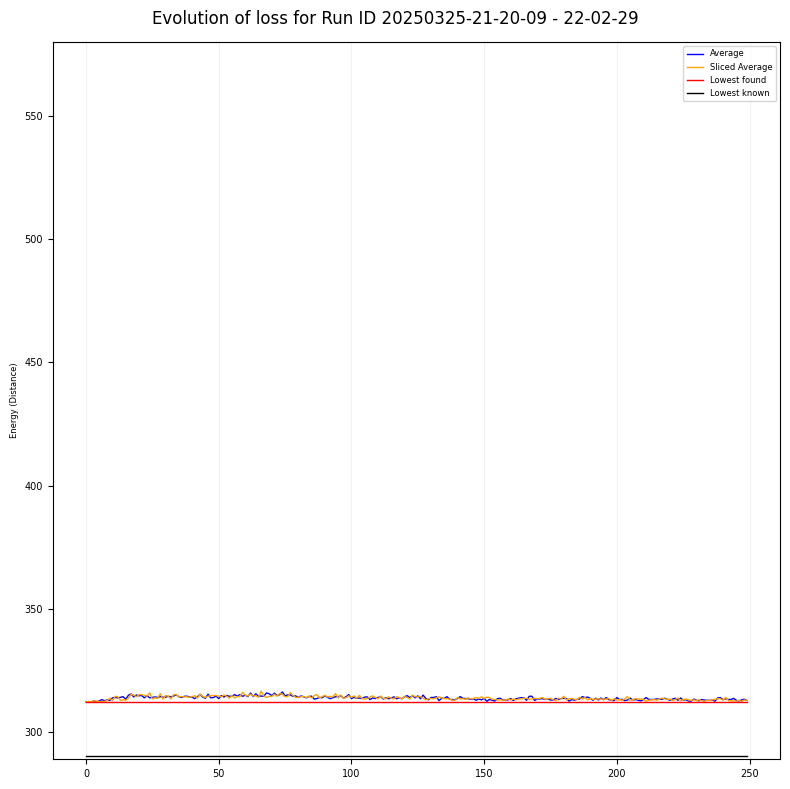

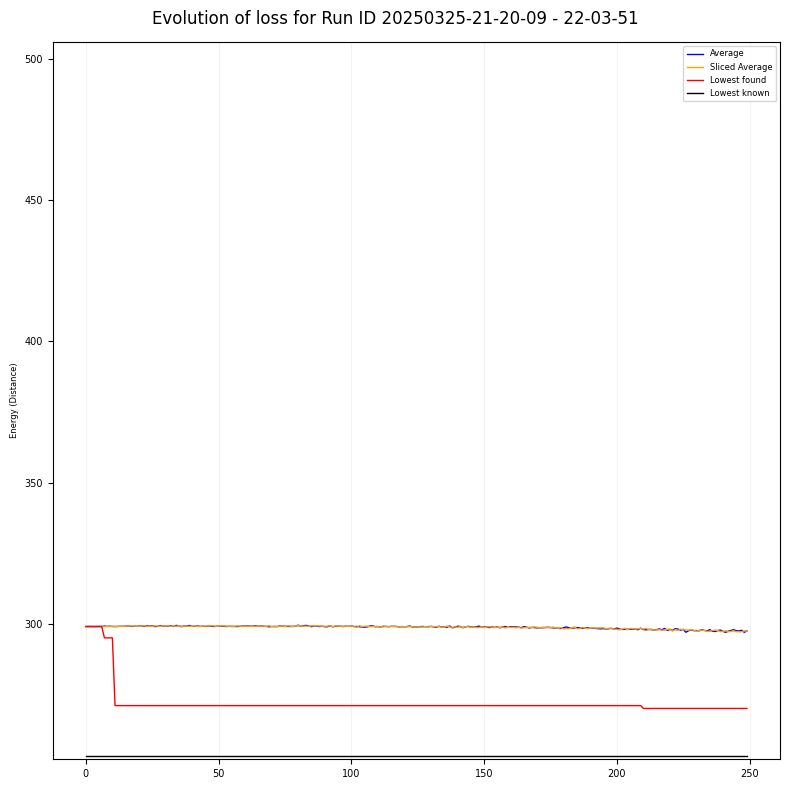

In [3]:

for keys, control_items in control_dict.items():
    subdatalogger = SubDataLogger(datalogger)
    data_dict = dict(control_items)
    quantum = format_boolean(data_dict['quantum'])
    locations = int(data_dict['locations'])
    slice = float(data_dict['slice'])
    shots = int(data_dict['shots'])
    iterations = int(data_dict['iterations'])
    gray = format_boolean(data_dict['gray'])
    hot_start_bool = format_boolean(data_dict['hot_start'])
    gradient_type = data_dict['gradient_type']
    formulation = data_dict['formulation']
    if not quantum:
        layers = int(data_dict['layers'])
        std_dev = float(data_dict['std_dev'])
        lr = float(data_dict['lr'])
        weight_decay = float(data_dict['weight_decay'])
        momentum = float(data_dict['momentum'])
    if quantum:
        mode = int(data_dict['mode'])
        alpha = float(data_dict['alpha'])
        big_a = float(data_dict['big_a'])
        c = float(data_dict['c'])
        gamma = float(data_dict['gamma'])
        eta = float(data_dict['eta'])
        s = float(data_dict['s'])

    data_dict['runid'] = datalogger.runid
    data_dict['subid'] = subdatalogger.subid
    data_dict['cache_max_size'] = CACHE_MAX_SIZE
    qubits = find_problem_size(locations, formulation)
    data_dict['qubits'] = qubits
    distance_array, best_dist = find_distances_array(locations, 
                                                     print_comments=False)
    data_dict['best_dist'] = best_dist  
    
    if quantum:
    #Define the VQC circuits with appropriate parameters
        params = define_parameters(qubits, mode)
        qc = vqc_circuit(qubits, params, mode)
    else:
        device = find_device()

    #define the cost function for this run
    cost_fn = cost_fn_fact(locations,
                           distance_array, 
                           gray, 
                           method=formulation
                           )

    if hot_start_bool:
        hot_start_list = hot_start(distance_array, locations)
        bin_hot_start_list =  hot_start_list_to_string(hot_start_list, 
                                                       locations, 
                                                       gray, 
                                                       formulation
                                                       )
        hot_start_dist = cost_fn(bin_hot_start_list)
        if quantum:
            init_rots = create_initial_rotations(qubits, 
                                                 mode, 
                                                 bin_hot_start_list,
                                                 hot_start=True
                                                 )
        else:
            bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
            unrepeated_input = bin_hot_start_list_tensor.float().to(device)
            my_input = unrepeated_input.repeat(shots, 1).requires_grad_(True)
            
    else:
        if quantum:
            init_rots = create_initial_rotations(qubits, mode)
        else:
            unrepeated_input = torch.full((shots,1), 0.5).float().to(device)
            my_input = unrepeated_input.repeat(shots, 1).requires_grad_(True)

    if quantum:
        bc = bind_weights(params, init_rots, qc)
        bc.measure_all()
    else:
        model = MyModel(qubits, layers, std_dev, cost_fn).to(device)

    if hot_start_bool:
    # find hot start distance
        if quantum:
            hot_start_dist, _, _ = cost_func_evaluate(cost_fn, bc, shots=shots, average_slice=slice)
        else:
            distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, 
                                             cost_fn
                                             ).clone().detach().requires_grad_(True)
            hot_start_dist = float(distance_tensor)

        data_dict['hot_start_dist'] = hot_start_dist
    else:
        data_dict['hot_start_dist'] = 'n/a'

    t0 = time.time()
    av_cost_list_all, lowest_list_all, sliced_cost_list_all = [], [], []

    if quantum:
        rots = copy.deepcopy(init_rots)
        
        index_list, sliced_list, lowest_list, _ , average_list, _ = \
        update_parameters_using_gradient(locations=locations, 
                                         iterations=iterations, 
                                         params=params,
                                         rots=rots,  
                                         cost_fn=cost_fn, 
                                         qc = qc, 
                                         shots=shots, 
                                         s=s, 
                                         eta=eta, 
                                         average_slice=slice, 
                                         gray=gray, 
                                         verbose=False, 
                                         gradient_type=gradient_type,
                                         alpha=alpha, 
                                         gamma=gamma, c=c,
                                         big_a=big_a,
                                         method=formulation,
                                         print_results=False
                                        )
        av_cost_list_all.append(average_list) 
        lowest_list_all.append(lowest_list)
        sliced_cost_list_all.append(sliced_list)
        best_dist_found, iteration_found = find_run_stats(lowest_list)
        data_dict['best_dist_found'] = best_dist_found
        data_dict['iteration_found'] = iteration_found
        subdatalogger.save_detailed_results(index_list,
                                            average_list,
                                            lowest_list,
                                            sliced_list,
                                            )
        
        subdatalogger.save_plot(index_list,
                                av_cost_list_all,
                                lowest_list_all,
                                sliced_cost_list_all,
                                best_dist,
                                )

    else:
        target, criterion, optimizer = get_ready_to_train(model, 
                                                          optimizer=gradient_type, 
                                                          lr=lr, 
                                                          weight_decay=weight_decay, 
                                                          momentum=momentum
                                                          )
        
        lowest_cost, epoch_lowest_cost, index_list, loss_history, lowest_list = \
            train_model(iterations,
                        model, 
                        my_input, 
                        target, 
                        criterion,
                        optimizer,
                        )
        
        av_cost_list_all.append(loss_history) 
        lowest_list_all.append(lowest_list)
        data_dict['best_dist_found'] = lowest_cost
        data_dict['iteration_found'] = epoch_lowest_cost
        subdatalogger.save_detailed_results(index_list,
                                    average_list,
                                    lowest_list,
                                    )
        
        subdatalogger.save_plot(index_list=index_list,
                        av_cost_list_all=av_cost_list_all,
                        lowest_list_all=lowest_list_all,
                        best_dist=best_dist,
                        )
     
    t1 = time.time()
    elapsed = t1-t0
    data_dict['elapsed'] = elapsed

    if hasattr(cost_fn, 'report_cache_stats'):
        items, hits, misses = cost_fn.report_cache_stats()
        data_dict['cache_items'] = items
        data_dict['cache_hits'] = hits
        data_dict['cache_misses'] = misses
    else:
        data_dict['cache_items'] = 0
        data_dict['cache_hits'] = 0
        data_dict['cache_misses'] = 0

    if hasattr(cost_fn, 'clear_cache'):
        cost_fn.clear_cache() 
        #need to clear cache so statistics are not cumulative
    
    subdatalogger.save_dict_to_csv(data_dict) 
